In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
train = pd.read_csv("C:/Data Science/Housing Regression Competition/train.csv")
test = pd.read_csv("C:/Data Science/Housing Regression Competition/test.csv")

df = (train, test)

df = pd.concat(df)

df.drop(columns=['Id'], inplace=True)

def encode_categorical_variables(df):
  """Encodes categorical variables in a pandas dataframe using one-hot encoding.

  Args:
      df (pandas.DataFrame): The dataframe containing the data to encode.

  Returns:
      pandas.DataFrame: The dataframe with encoded categorical variables.
  """
  categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
  for col in categorical_cols:
    encoded_df = pd.get_dummies(df[col])
    encoded_df.columns = [f"{col}_{name}" for name in encoded_df.columns]
    df = pd.concat([df, encoded_df], axis=1).drop(col, axis=1)
  return df

# Example usage
df = encode_categorical_variables(df.copy())


df['LotFrontage'] = df['LotFrontage'].fillna(0)
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

df = df.replace({True: 1, False: 0})

null_counts = df.isnull().sum()

null_counts_sorted = null_counts.sort_values(ascending=True)

# Display the sorted null counts
print("Number of null values in each column (sorted):", null_counts_sorted)

Number of null values in each column (sorted): MSSubClass             0
BsmtFinType1_BLQ       0
BsmtFinType1_ALQ       0
BsmtExposure_No        0
BsmtExposure_Mn        0
                    ... 
GarageCars             1
TotalBsmtSF            1
BsmtFullBath           2
BsmtHalfBath           2
SalePrice           1459
Length: 288, dtype: int64


C:\Users\gaith\AppData\Local\Temp\ipykernel_20176\3177886889.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


In [11]:
df.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_T

In [12]:
def separate_train_test(df):
  """Separates training and test data based on the presence of a value in the 'sale price' column.

  Args:
      df (pandas.DataFrame): The combined dataframe containing training and test data.

  Returns:
      tuple: A tuple containing two pandas DataFrames - the training dataframe and the test dataframe.
  """
  train_df = df[df['SalePrice'].notna()]  # Select rows with value in 'SalePrice' (training data)
  test_df = df[df['SalePrice'].isna()]    # Select rows with missing value in 'SalePrice' (test data)
  return train_df, test_df

# Example usage
train_df, test_df = separate_train_test(df.copy())  # Copy to avoid modifying original df

In [13]:
null_counts = train_df.isnull().sum()

null_counts_sorted = null_counts.sort_values(ascending=True)

# Display the sorted null counts
print("Number of null values in each column (sorted):", null_counts_sorted)

Number of null values in each column (sorted): MSSubClass               0
BsmtFinType1_BLQ         0
BsmtFinType1_ALQ         0
BsmtExposure_No          0
BsmtExposure_Mn          0
                        ..
Condition1_PosN          0
Condition1_PosA          0
Condition1_Norm          0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 288, dtype: int64


In [14]:
x = train_df.drop(columns=['SalePrice'])
y = train_df['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform scaler on training features
x_train_scaled = scaler.fit_transform(x_train)

# Transform testing features using the fitted scaler
x_test_scaled = scaler.transform(x_test)

In [15]:
rf = RandomForestRegressor(random_state=0)

# Fit the RandomForestRegressor on the training data
rf.fit(x_train_scaled, y_train)

# Predict on the testing data
pred_test = rf.predict(x_test_scaled)

# Calculate the mean squared error
rmse = mean_squared_error(y_test, pred_test, squared=False)
print("Root Mean Squared Error:", rmse)

from sklearn.metrics import r2_score

# Predict on test data
y_pred = rf.predict(x_test_scaled)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

# Calculate number of predictors (features)
num_predictors = x_train_scaled.shape[1]

# Calculate number of samples
num_samples = len(y_test)

# Calculate adjusted R-squared
adjusted_r_squared = 1 - (1 - r_squared) * (num_samples - 1) / (num_samples - num_predictors - 1)

print("Adjusted R-squared:", adjusted_r_squared)
print("R-squared:", r_squared)

Root Mean Squared Error: 26564.977394490135
Adjusted R-squared: -7.279132695922508
R-squared: 0.8861974887158418


C:\Users\gaith\PycharmProjects\Housing Regression\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


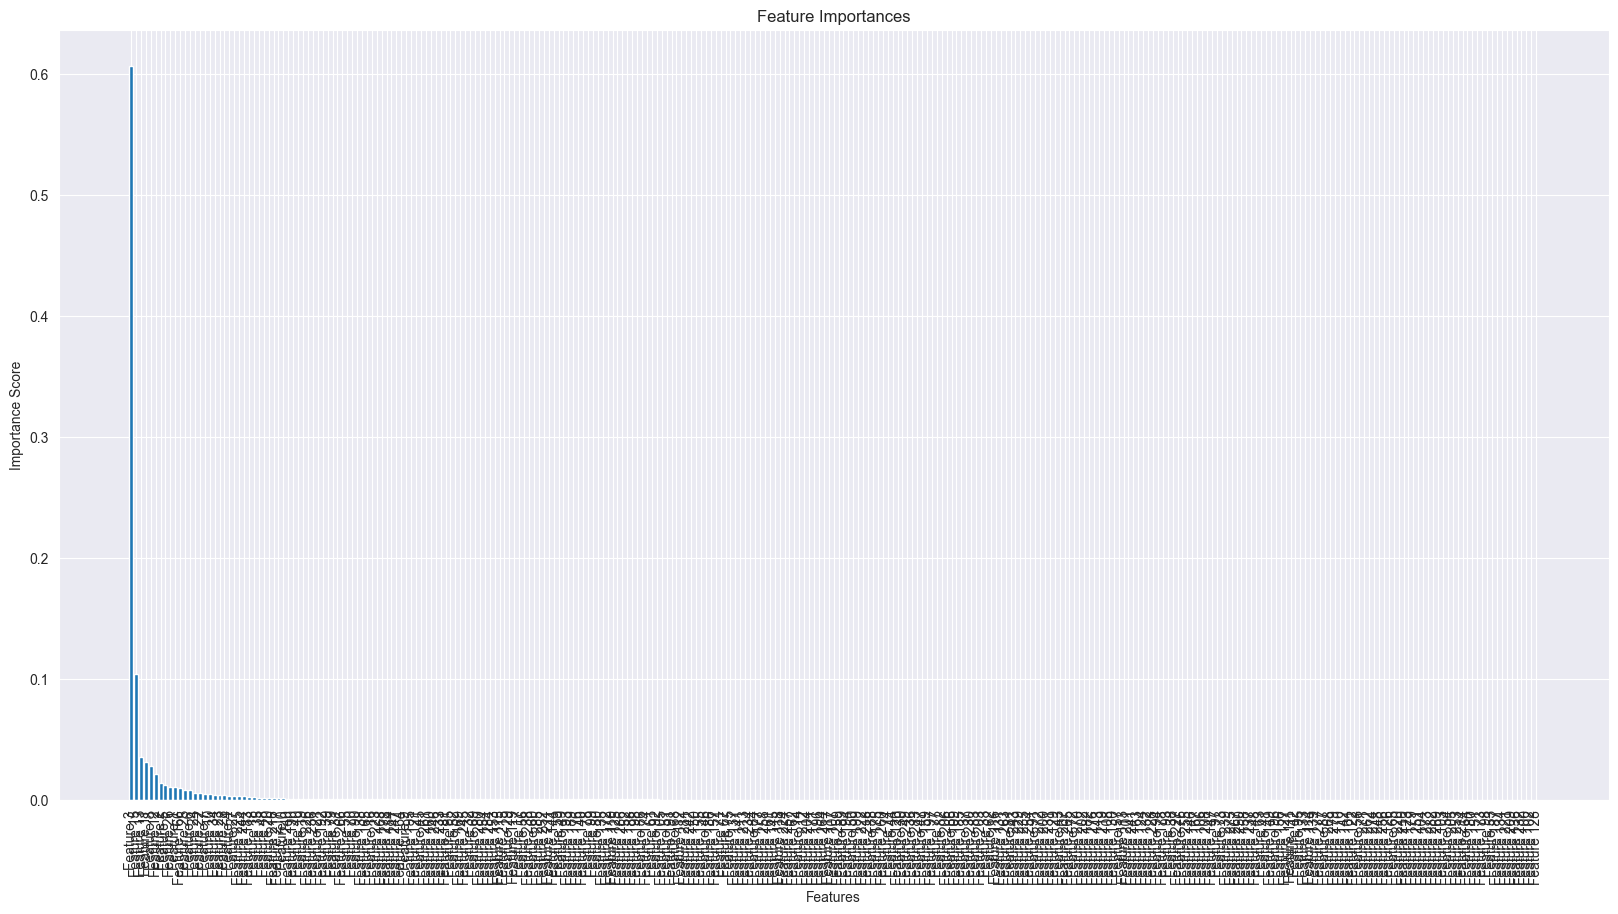

In [16]:
# Get feature importances from the trained RandomForestRegressor
importances = rf.feature_importances_

# Get the indices of features sorted by importance
sorted_indices = np.argsort(importances)[::-1]

# Get the names of the features
feature_names = [f'Feature {i}' for i in range(x_train_scaled.shape[1])]

# Plot the feature importances
plt.figure(figsize=(20, 10))
plt.bar(range(x_train_scaled.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(x_train_scaled.shape[1]), np.array(feature_names)[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.show()

In [17]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Define hyperparameter ranges to explore
learning_rates = [0.1, 0.5, 1.0]
max_depths = [1, 2, 3]

# Create and fit models with different hyperparameter combinations
cv_scores = []
for lr in learning_rates:
    for max_depth in max_depths:
        XG_boost_model = XGBRegressor(
            estimator=DecisionTreeRegressor(max_depth=max_depth),
            n_estimators=500,  # Adjust as needed based on initial exploration
            learning_rate=lr,
        )
        scores = cross_val_score(XG_boost_model, x_train_scaled, y_train, cv=5)
        cv_scores.append((lr, max_depth, np.mean(scores)))

# Find the best hyperparameter combination based on cross-validation
best_lr, best_depth, best_score = max(cv_scores, key=lambda x: x[2])

print("Best Hyperparameters:", ("learning_rate:", best_lr, "max_depth:", best_depth))
print("Best Cross-Validation Score:", best_score)

# Create and fit the final model with the best hyperparameters
XG_boost_model_optimal = XGBRegressor(
    estimator=DecisionTreeRegressor(max_depth=best_depth),
    n_estimators=50,  # Use the number of trees from initial analysis
    learning_rate=best_lr,
)
XG_boost_model_optimal.fit(x_train_scaled, y_train)

# Make predictions and calculate RMSE
y_pred_optimal = XG_boost_model_optimal.predict(x_test)
rmse = mean_squared_error(y_test, y_pred_optimal, squared=False)
print("Root Mean Squared Error:", rmse)

# Feature importance analysis (optional)
print("Feature Importances:", XG_boost_model_optimal.feature_importances_)

C:\Users\gaith\PycharmProjects\Housing Regression\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:12:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\gaith\PycharmProjects\Housing Regression\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:12:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\gaith\PycharmProjects\Housing Regression\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:12:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warning

Best Hyperparameters: ('learning_rate:', 0.1, 'max_depth:', 1)
Best Cross-Validation Score: 0.8257346915640307
Root Mean Squared Error: 199542.788129156
Feature Importances: [6.94973394e-04 2.88902689e-03 5.81565499e-03 4.17997777e-01
 3.47485067e-03 7.33379787e-03 5.01878746e-03 1.37979107e-03
 1.00202663e-02 3.58425500e-03 2.40926514e-03 1.72628760e-02
 1.39648169e-02 1.01480456e-02 1.94929074e-03 2.67667584e-02
 3.66331078e-03 8.41063738e-04 3.57988919e-03 2.15706509e-03
 1.66390371e-03 2.51813966e-04 2.33901087e-02 1.31876245e-02
 2.80876993e-03 2.64385547e-02 4.47341846e-03 1.28423679e-03
 5.97510254e-03 1.33288011e-03 0.00000000e+00 1.85881380e-03
 7.10827240e-04 0.00000000e+00 9.90276923e-04 1.33291143e-03
 1.45912380e-03 6.43451582e-04 0.00000000e+00 4.78306832e-03
 1.17577324e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.16393040e-03 0.00000000e+00 0.00000000e+00
 3.86444759e-03 6.00102963e-03 1.27145345e-03 6.14534947e-04
 2.71642441e-03 0.00000000e+00 0.

C:\Users\gaith\PycharmProjects\Housing Regression\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:12:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\gaith\PycharmProjects\Housing Regression\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
from xgboost import XGBRegressor

# Define the model
model = Sequential()
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')

# Train the model
model.fit(x_train_scaled, y_train, epochs=500, batch_size=256)

# Make predictions on training data with the neural network
nn_predictions_train = model.predict(x_train)

# Stack features (neural network predictions + original features)
X_train_stacked = np.concatenate((x_train, nn_predictions_train.reshape(-1, 1)), axis=1)

# Train XGBoost model with stacked features
gbm = XGBRegressor()
gbm.fit(X_train_stacked, y_train)

# Make predictions on test data with the neural network
nn_predictions_test = model.predict(x_test)

# Stack features for test data
X_test_stacked = np.concatenate((x_test, nn_predictions_test.reshape(-1, 1)), axis=1)

# Make final predictions on test data with XGBoost
y_pred = gbm.predict(X_test_stacked)

# Evaluate the model (same as before)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 146945552498920323786345676724502528.0000
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92317212034638484585121115537408.0000 
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75429896510056475691735001858048.0000 
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61631720118116057977375386763264.0000 
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50357592245103126097651012993024.0000 
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 41145809613397017795191495458816.0000
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33619124503135348806771422527488.0000 
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27469277755277863297649165205504.0000 
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22444394511011131737791390547968.0000 
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18338703506578548095371360337920.0000 
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━

C:\Users\gaith\PycharmProjects\Housing Regression\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)  # Scale test data as well

model2 = Sequential()
model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=1, activation='linear'))

model2.compile(loss='mean_squared_error', optimizer='sgd')

model2.fit(x_train_scaled, y_train, epochs=500, batch_size=128)

# Make predictions on training data with the neural network
nn_predictions_train = model2.predict(x_train_scaled)  # Use scaled data for prediction

# Train XGBoost model with original features (not stacked)
gbm = XGBRegressor()
gbm.fit(x_train, y_train)  # Train on unscaled features

# Make predictions on test data with the neural network
nn_predictions_test = model2.predict(x_test_scaled)  # Use scaled data for prediction

# Make final predictions on test data with XGBoost
y_pred = gbm.predict(x_test)  # Predict on test data

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

# Calculate adjusted R-squared (assuming you have r_squared and num_predictors defined)
adjusted_r_squared = 1 - (1 - r_squared) * (num_samples - 1) / (num_samples - num_predictors - 2)
print("Adjusted R-squared:", adjusted_r_squared)
print("R-squared:", r_squared)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 124676539119669820621514726178816.0000
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157564411670909085295577137152.0000 
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105191280089899291492504043520.0000 
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70226552807445120324779114496.0000 
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46883815002390255249511153664.0000 
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31299998525370701739846533120.0000 
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20896122231578447716858986496.0000 
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13950417204317324122691469312.0000 
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9313409266512978822349979648.0000  
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6217707961740990881552400384.0000 
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 88

C:\Users\gaith\PycharmProjects\Housing Regression\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
# Ensure that the model has been trained and is ready for predictions
if 'SalePrice' in test_df.columns:
    test_df = test_df.drop('SalePrice', axis=1)

scaled_test_df = scaler.transform(test_df)

# Now use the scaled_test_df for making predictions
predicted_prices = model.predict(scaled_test_df)

# Create a DataFrame to store the predictions
sample_submission_df = pd.DataFrame()
sample_submission_df['SalePrice'] = predicted_prices.flatten()  # Flatten is used to convert array shape from (n, 1) to (n,)

# Save the predictions to a CSV file
sample_submission_df.to_csv('C:/Data Science/Housing Regression Competition/NN_Model_Submission.csv', index=False)

# Optionally, display the first few rows to confirm
print(sample_submission_df.head())

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
       SalePrice
0  180517.046875
1  180517.046875
2  180517.046875
3  180517.046875
4  180517.046875


In [ ]:
print(model.input_shape)
print(test_df.shape)

In [26]:
(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,715 (77.02 KB)

 Trainable params: 19,713 (77.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [27]:
test_df.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_T

In [34]:
# Now use the scaled_test_df for making predictions
predicted_prices = XG_boost_model_optimal.predict(scaled_test_df)

# Create a DataFrame to store the predictions
NN_sample_submission_df = pd.DataFrame()
NN_sample_submission_df['SalePrice'] = predicted_prices.flatten()  # Flatten is used to convert array shape from (n, 1) to (n,)

# Save the predictions to a CSV file
NN_sample_submission_df.to_csv('C:/Data Science/Housing Regression Competition/NN_Model_Submission.csv', index=False)

# Optionally, display the first few rows to confirm
print(NN_sample_submission_df.head())

       SalePrice
0  167594.203125
1  175269.015625
2  182402.953125
3  192443.968750
4  196268.765625
